In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from snsphd import viz
import math
import orjson
Colors, pallet = viz.phd_style(jupyterStyle = True, grid = True, axese_width=0.5, text = 6, svg_mode=True)

from enum import Enum
from dataclasses import dataclass, fields, field, _MISSING_TYPE 

from load_schema import Decode, Result, Event

import matplotlib as mpl
import os

# set the DPI for all figures
mpl.rcParams['figure.dpi'] = 100

from snsphd.layout import bisect

from numba import njit
from snsphd.viz import save_bokeh_dark_json
from snsphd.layout import bisect

from pydantic import BaseModel

In [2]:
db_values = np.arange(16,50, 2).tolist()
print(db_values)

# need type hints for intellisense to work
def decode_from_folder(folder_path: str, db_values: list[int]) -> list[Decode]:
    decodes = []
    for db in db_values:
        filename = f"decode_20GHz{db}.0.json"
        filepath = os.path.join(folder_path, filename)
        with open(filepath, "r") as f:
            data = orjson.loads(f.read())
            decode = Decode(**data)
            decodes.append(decode)
    return decodes

decodes = decode_from_folder("../inter", db_values)

[16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]


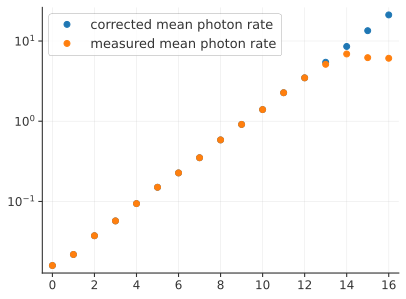

In [3]:
def calculate_mfr(struct: list[Decode]) -> list[float]:
    mfrs = []
    for d in range(len(struct)):
        missing = 0
        found = 0
        for res in struct[d].results[0]:
            result: Result = res.result
            if result == Result.MISSING:
                missing += 1
            if (result == Result.CORRECT) or (result == Result.INCORRECT):
                found += 1
        total = missing + found

        ratio_of_vacuum = missing/total
        mfr = -np.log(ratio_of_vacuum)
        mfrs.append(mfr)

    return mfrs


def calculate_corrected_mfr(struct: list[Decode]) -> list[float]:

    mfr = calculate_mfr(decodes)

    mfr = np.flip(mfr)
    ln_mfr = np.log(mfr)
    x = np.arange(len(ln_mfr))
    slope, intercept = np.polyfit(x[:-3], ln_mfr[:-3], 1)
    ln_mfr_ext = slope*x + intercept

    ln_mfr_corrected = ln_mfr.copy()
    ln_mfr_corrected[-4:] = ln_mfr_ext[-4:]
    mfr_corrected = np.exp(ln_mfr_corrected)

    plt.plot(x, mfr_corrected, 'o', label="corrected mean photon rate")
    plt.plot(x, mfr, 'o', label="measured mean photon rate")
    plt.yscale('log')
    plt.legend()

    # put the order back to what it was
    mfr = np.flip(mfr)
    mfr_corrected = np.flip(mfr_corrected)
    return mfr_corrected

mfr_corrected = calculate_corrected_mfr(decodes)

In [4]:
from gmm_solver import GMData, correction_from_gaussian_model
from worker import decode_results

class Arr:
    def __init__(self):
        self.x_correct = []
        self.y_correct = []
        self.x_incorrect = []
        self.y_incorrect = []
        self.x_gaussian_fixed = []
        self.y_gaussian_fixed = []
        self.x_gaussian_corrupted = []
        self.y_gaussian_corrupted = []

    def numpyify(self):
        for item in self.__dict__:
            self.__dict__[item] = np.array(self.__dict__[item])


a = Arr()

# fig, ax = plt.subplots(1,1, figsize=(16,12))
for stream in decodes[10].results:
    for event in stream:
        if event.result == Result.CORRECT:
            a.x_correct.append(event.tag_x - 50*event.true)
            a.y_correct.append(event.tag_y - 50*event.true)

        if event.result == Result.INCORRECT:
            a.x_incorrect.append(event.tag_x - 50*event.true)
            a.y_incorrect.append(event.tag_y - 50*event.true)


        if (event.gaussian_measured != event.measured) and (event.result == Result.CORRECT):
            a.x_gaussian_fixed.append(event.tag_x - 50*event.true)
            a.y_gaussian_fixed.append(event.tag_y - 50*event.true)

        

        if (event.true == event.measured) and (event.result == Result.INCORRECT):
            a.x_gaussian_corrupted.append(event.tag_x - 50*event.true)
            a.y_gaussian_corrupted.append(event.tag_y - 50*event.true)


a.numpyify()

dB_idx = 7
recalculate_offsets = False

if recalculate_offsets == True:
    max_offsets_vs_dB = []
    for dB_idx in range(len(decodes)):
        print("dB_idx: ", dB_idx)
        decode: Decode = decodes[dB_idx]

        list_cc = []
        list_org_cc = []

        offsets = np.arange(-0.12, 0.02, .002).tolist()
        for offset in offsets:
            new_results = decode_results(decode, slice = 0, offset=offset)
            cc = 0
            org_cc = 0
            for event in new_results:
                if event.result == Result.CORRECT:
                    cc += 1
                if event.true == event.measured:
                    org_cc += 1
            cc = cc/len(new_results)
            org_cc = org_cc/len(new_results)
            list_cc.append(cc)
            list_org_cc.append(org_cc)
            print(f"cc: {round(cc,4)}, org_cc: {round(org_cc,4)}, offset: {offset}")
            # print(list_cc)
        max_offset = offsets[np.argmax(list_cc)]
        max_offsets_vs_dB.append(max_offset)

    offsets_dict = dict(max_offsets_vs_dB=max_offsets_vs_dB, db_values=db_values)
    with open("offsets.json", "w") as f:
        f.write(json.dumps(offsets_dict))
else:
    with open("offsets.json", "r") as f:
        offset_dict = json.loads(f.read())

    max_offsets_vs_dB = offset_dict["max_offsets_vs_dB"]


print(max_offsets_vs_dB)

[0.014000000000000123, -0.07399999999999995, -0.04999999999999993, -0.03599999999999992, -0.04799999999999993, -0.05999999999999994, -0.051999999999999935, -0.06599999999999995, -0.12, -0.10199999999999998, -0.118, -0.08999999999999997, 0.002000000000000113, -0.06399999999999995, -0.06599999999999995, -0.0019999999999998908, -0.12]


In [5]:
import concurrent.futures
from worker import MultiprocessLoaderCorrector, caller, CallerResults
from multiprocessing import Pool

from worker import DecodingResults


    
recompute = False
if recompute:
    # takes several minutes
    with Pool(processes=12) as pool: # set the number of processes to use    
        list_caller_results: list[CallerResults] = pool.map(caller, decodes)
    dec = DecodingResults(list_caller_results=list_caller_results)
    a = dec.json()
    with open("../inter/output.json", "w") as file:
        file.write(a)

else:
    # this takes a few seconds
    with open("../inter/output.json", "rb") as file:
        dic = orjson.loads(file.read())


        dec = DecodingResults(**dic)
    

In [6]:
len(dec.list_caller_results[0].gmm_optimized_results.filled)

26739

In [7]:
improvements = []
max_list_ccs = []
max_list_org_ccs = []
for st in dec.list_caller_results:
    max_list_cc = max(st.list_cc)
    #print("max list cc: ", max_list_cc)
    max_list_org_cc = max(st.list_org_cc)
    #print("max list org cc: ", max_list_org_cc)
    
    arg_max_list_cc = np.argmax(st.list_cc)
    arg_max_list_org_cc = np.argmax(st.list_org_cc)

    if max_list_cc != 1 and max_list_org_cc != 1:
        improvement = (1-max_list_org_cc)/(1-max_list_cc)
    else: 
        improvement = None

    improvements.append(improvement)
    max_list_ccs.append(max_list_cc)
    max_list_org_ccs.append(max_list_org_cc)

    #print(f"cc: {round(max_list_cc,4)} (at index {arg_max_list_cc}), org_cc: {round(max_list_org_cc,4)} (at index {arg_max_list_org_cc})", "max here: ", st.offsets[arg_max_list_cc], "max there: ", st.max_offset, "improvement: ", improvement)


Text(0.5, 0, 'mean photon rate $\\mu$')

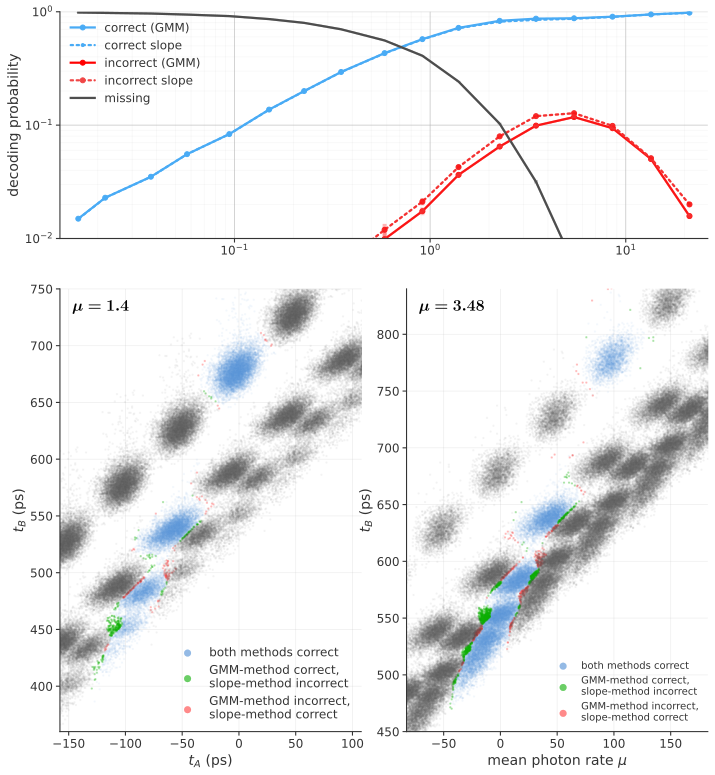

In [8]:
from worker import NumpyConvertingStruct, OutExport, OutDetectedExport, OutExport2D
from worker import export_plot_metrics, export_detected_plot_metrics, export_2d_data

plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
    
s = export_plot_metrics(dec)

s_d = export_detected_plot_metrics(dec)

dB_idx1 = 6
dB_idx2 = 4

s_2d = export_2d_data(dec.list_caller_results[dB_idx1])

s_2d_2 = export_2d_data(dec.list_caller_results[dB_idx2])


fig = plt.figure(figsize=(9,10))

middle, top = bisect([0,0,1,1], direction="horiz", offset=0.65, spacing=0.07)


bottom_left, bottom_right = bisect(middle, direction="vert", offset=0.5, spacing=0.07)


ax1 = fig.add_axes(top)

ax2 = fig.add_axes(bottom_left)
ax3 = fig.add_axes(bottom_right)

missing_color = "#4d4d4d"
incorrect_color = "#f04646"
correct_color = "#49abf5"

ax1.plot(mfr_corrected, s.correct_gmm, label="correct (GMM)", color = correct_color, ls="-", marker="o", markersize=5, )
ax1.plot(mfr_corrected, s.correct_slope, label="correct slope", color = correct_color, ls=":", marker="o", markersize=3, )


ax1.plot(mfr_corrected, s.incorrect_gmm, color = "red", ls="-", marker="o", markersize=5, label="incorrect (GMM)")
ax1.errorbar(mfr_corrected, s.incorrect_gmm, yerr = s_d.incorrect_gmm_d_err, color = incorrect_color, ls="-", marker="o", markersize=5, alpha=0.3, elinewidth=4, capsize=0)


ax1.plot(mfr_corrected, s.incorrect_slope, label="incorrect slope", color = incorrect_color, ls=":", marker="o", markersize=5, )
ax1.errorbar(mfr_corrected, s.incorrect_slope, yerr = s_d.incorrect_slope_d_err, color = "red", ls=":", marker="o", markersize=5, alpha=0.3, elinewidth=4, capsize=0)




# missing
ax1.plot(mfr_corrected, s.missing, label="missing", color=missing_color)
ax1.errorbar(mfr_corrected, s.missing, yerr = np.sqrt(s.missing*s.lengths)/s.lengths, color = missing_color, alpha=0.3, elinewidth=4, capsize=0)


ax1.legend(fontsize=12, frameon=False)
# ax1.set_ylim(0, 0.3)
ax1.set_xscale('log')
ax1.grid(which='both', alpha=0.1)
ax1.grid(which='major', alpha=0.7)
ax1.set_yscale('log')

ax1.set_ylim(0.01, 1)


ax1.set_ylabel("decoding probability")



green_color = "#09ad00"
red_color = "#ff3d3d"
blue_color = "#4e8dd4"
grey_color= "#525252"

marker_size = 2.8

ax2.scatter(s_2d.both_correct[:, 0], s_2d.both_correct[:, 1], label="both methods correct", color=blue_color, s=marker_size, rasterized=True, alpha=0.08)
ax2.scatter(s_2d.gmm_correct_slope_incorrect[:, 0], s_2d.gmm_correct_slope_incorrect[:, 1], label="GMM-method correct,\nslope-method incorrect", color=green_color, s=marker_size, rasterized=True, alpha=0.4)
ax2.scatter(s_2d.gmm_incorrect_slope_correct[:, 0], s_2d.gmm_incorrect_slope_correct[:, 1], label="GMM-method incorrect,\nslope-method correct", color=red_color, s=marker_size, rasterized=True, alpha=0.4)

# ax2.scatter(s_2d.gmm_correct[:, 0] - 50, s_2d.gmm_correct[:, 1] - 50, color=grey_color, s=marker_size, rasterized=True, alpha=0.08)
# ax2.scatter(s_2d.gmm_correct[:, 0] + 50, s_2d.gmm_correct[:, 1] + 50, color=grey_color, s=marker_size, rasterized=True, alpha=0.08)

for i in range(-7, 7):
    if i == 0: 
        continue
    ax2.scatter(s_2d.gmm_correct[:, 0] + i*50, s_2d.gmm_correct[:, 1] + i*50, color=grey_color, s=marker_size, rasterized=True, alpha=0.08)

# ax2.scatter(s_2d.gmm_correct[:, 0], s_2d.gmm_correct[:, 1], label="slope correct", color="green", s=marker_size, rasterized=True, alpha=0.6)


# ax2.set_xlim()
ax2.axis('equal')
ax2.set_ylim(360, 750)
ax2.set_xlim(-125, 75)

ax2.set_xlabel("$t_A$ (ps)")
ax2.set_ylabel("$t_B$ (ps)")

lgnd = ax2.legend(numpoints=1, fontsize=12, frameon=False, loc="lower right")
lgnd.legend_handles[0]._sizes = [47]
lgnd.legend_handles[0]._alpha = 0.6
lgnd.legend_handles[1]._sizes = [47]
lgnd.legend_handles[1]._alpha = 0.6
lgnd.legend_handles[2]._sizes = [47]
lgnd.legend_handles[2]._alpha = 0.6




ax3.scatter(s_2d_2.both_correct[:, 0], s_2d_2.both_correct[:, 1], label="both methods correct", color=blue_color, s=marker_size, rasterized=True, alpha=0.08)
ax3.scatter(s_2d_2.gmm_correct_slope_incorrect[:, 0], s_2d_2.gmm_correct_slope_incorrect[:, 1], label="GMM-method correct,\nslope-method incorrect", color=green_color, s=marker_size, rasterized=True, alpha=0.4)
ax3.scatter(s_2d_2.gmm_incorrect_slope_correct[:, 0], s_2d_2.gmm_incorrect_slope_correct[:, 1], label="GMM-method incorrect,\nslope-method correct", color=red_color, s=marker_size, rasterized=True, alpha=0.4)

for i in range(-7, 7):
    if i == 0: 
        continue
    ax3.scatter(s_2d_2.gmm_correct[:, 0] + i*50, s_2d_2.gmm_correct[:, 1] + i*50, color=grey_color, s=marker_size, rasterized=True, alpha=0.08)

# ax3.scatter(s_2d_2.gmm_correct[:, 0], s_2d_2.gmm_correct[:, 1], label="slope correct", color="green", s=marker_size, rasterized=True, alpha=0.6)
# remove legend border:


lgnd = ax3.legend(numpoints=1, fontsize=10, frameon=False, loc="lower right")
lgnd.legend_handles[0]._sizes = [47]
lgnd.legend_handles[0]._alpha = 0.6
lgnd.legend_handles[1]._sizes = [47]
lgnd.legend_handles[1]._alpha = 0.6
lgnd.legend_handles[2]._sizes = [47]
lgnd.legend_handles[2]._alpha = 0.6


# print(lgnd.legend_handles[0].__dict__)

# ax2.set_xlim()
ax3.axis('equal')
ax3.set_ylim(450, 840)
ax3.set_xlim(-50, 150)

ax3.set_xlabel("$t_A$ (ps)")
_ = ax3.set_ylabel("$t_B$ (ps)")

ax2.text(0.04, 0.96, rf"$\bm{{\mu = {round(mfr_corrected[dB_idx1],2)}}}$", ha='left', va='center', fontsize=16, color='k', transform=ax2.transAxes, usetex=True)
ax3.text(0.04, 0.96, rf"$\bm{{\mu = {round(mfr_corrected[dB_idx2],2)}}}$", ha='left', va='center', fontsize=16, color='k', transform=ax3.transAxes, usetex=True)
ax3.set_xlabel(r"mean photon rate $\mu$")

# viz.save_light_dark_all(fig, "../figs/gmm_effectiveness_analysis")

['..', 'figs', 'gmm_effectiveness_analysis']
../figs/
pickleable
found fill_bewteen poly collection


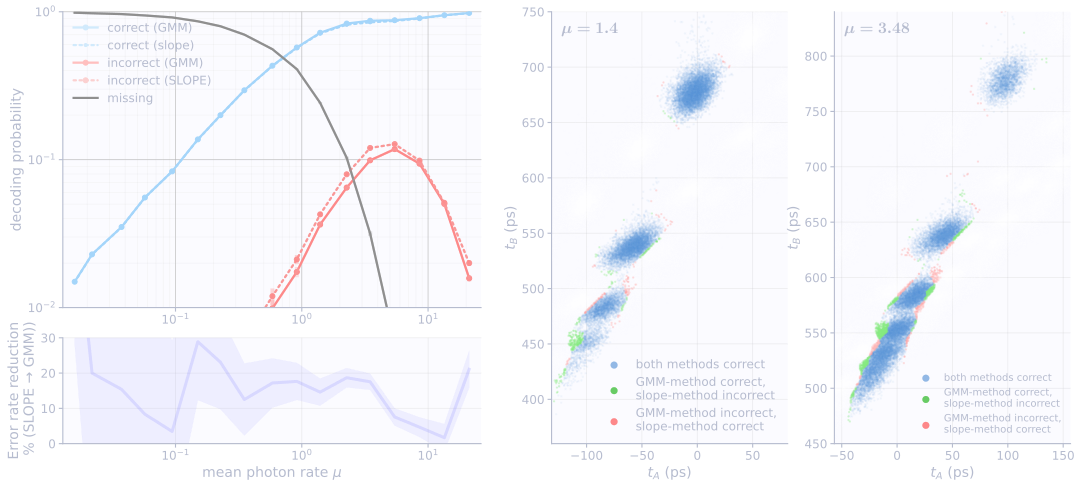

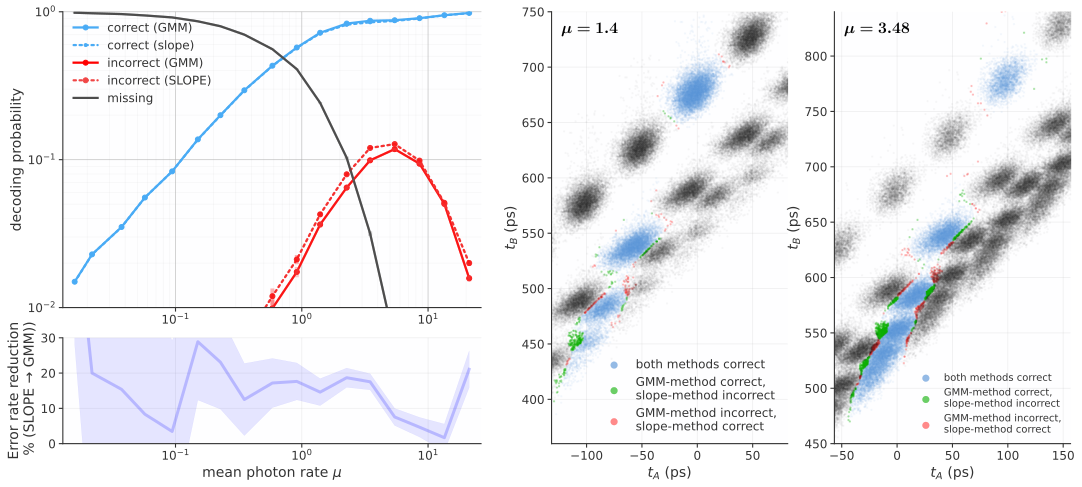

In [31]:
fig = plt.figure(figsize=(14, 6))

left, right = bisect([0, 0, 1, 1], direction="vert", offset=0.45, spacing=0.07)


right_middle, right_right = bisect(right, direction="vert", offset=0.5, spacing=0.09)

left_bottom, left_top = bisect(left, direction="horiz", offset=0.28, spacing=0.07)


ax1 = fig.add_axes(left_top)

ax2 = fig.add_axes(right_middle)
ax3 = fig.add_axes(right_right)
ax4 = fig.add_axes(left_bottom, sharex=ax1)

missing_color = "#4d4d4d"
incorrect_color = "#f04646"
correct_color = "#49abf5"

ax1.plot(
    mfr_corrected,
    s.correct_gmm,
    label="correct (GMM)",
    color=correct_color,
    ls="-",
    marker="o",
    markersize=5,
)
ax1.plot(
    mfr_corrected,
    s.correct_slope,
    label="correct (slope)",
    color=correct_color,
    ls=":",
    marker="o",
    markersize=3,
)


ax1.plot(
    mfr_corrected,
    s.incorrect_gmm,
    color="red",
    ls="-",
    marker="o",
    markersize=5,
    label="incorrect (GMM)",
)
ax1.errorbar(
    mfr_corrected,
    s.incorrect_gmm,
    yerr=s_d.incorrect_gmm_d_err,
    color=incorrect_color,
    ls="-",
    marker="o",
    markersize=5,
    alpha=0.3,
    elinewidth=4,
    capsize=0,
)


ax1.plot(
    mfr_corrected,
    s.incorrect_slope,
    label="incorrect (SLOPE)",
    color=incorrect_color,
    ls=":",
    marker="o",
    markersize=5,
)
ax1.errorbar(
    mfr_corrected,
    s.incorrect_slope,
    yerr=s_d.incorrect_slope_d_err,
    color="red",
    ls=":",
    marker="o",
    markersize=5,
    alpha=0.3,
    elinewidth=4,
    capsize=0,
)


# missing
ax1.plot(mfr_corrected, s.missing, label="missing", color=missing_color)
ax1.errorbar(
    mfr_corrected,
    s.missing,
    yerr=np.sqrt(s.missing * s.lengths) / s.lengths,
    color=missing_color,
    alpha=0.3,
    elinewidth=4,
    capsize=0,
)


ax1.legend(fontsize=12, frameon=False)
# ax1.set_ylim(0, 0.3)
ax1.set_xscale("log")
ax1.grid(which="both", alpha=0.1)
ax1.grid(which="major", alpha=0.7)
ax1.set_yscale("log")

ax1.set_ylim(0.01, 1)


ax1.set_ylabel("decoding probability")


green_color = "#09ad00"
red_color = "#ff3d3d"
blue_color = "#4e8dd4"
grey_color = "#000000"

marker_size = 2.8

ax2.scatter(
    s_2d.both_correct[:, 0],
    s_2d.both_correct[:, 1],
    label="both methods correct",
    color=blue_color,
    s=marker_size,
    rasterized=True,
    alpha=0.08,
)
ax2.scatter(
    s_2d.gmm_correct_slope_incorrect[:, 0],
    s_2d.gmm_correct_slope_incorrect[:, 1],
    label="GMM-method correct,\nslope-method incorrect",
    color=green_color,
    s=marker_size,
    rasterized=True,
    alpha=0.4,
)
ax2.scatter(
    s_2d.gmm_incorrect_slope_correct[:, 0],
    s_2d.gmm_incorrect_slope_correct[:, 1],
    label="GMM-method incorrect,\nslope-method correct",
    color=red_color,
    s=marker_size,
    rasterized=True,
    alpha=0.4,
)

# ax2.scatter(s_2d.gmm_correct[:, 0] - 50, s_2d.gmm_correct[:, 1] - 50, color=grey_color, s=marker_size, rasterized=True, alpha=0.08)
# ax2.scatter(s_2d.gmm_correct[:, 0] + 50, s_2d.gmm_correct[:, 1] + 50, color=grey_color, s=marker_size, rasterized=True, alpha=0.08)

for i in range(-7, 7):
    if i == 0:
        continue
    ax2.scatter(
        s_2d.gmm_correct[:, 0] + i * 50,
        s_2d.gmm_correct[:, 1] + i * 50,
        color=grey_color,
        s=marker_size,
        rasterized=True,
        alpha=0.04,
    )

# ax2.scatter(s_2d.gmm_correct[:, 0], s_2d.gmm_correct[:, 1], label="slope correct", color="green", s=marker_size, rasterized=True, alpha=0.6)


# ax2.set_xlim()
ax2.axis("equal")
ax2.set_ylim(360, 750)
ax2.set_xlim(-125, 75)

ax2.set_xlabel("$t_A$ (ps)")
ax2.set_ylabel("$t_B$ (ps)")

lgnd = ax2.legend(numpoints=1, fontsize=12, frameon=False, loc="lower right")
lgnd.legend_handles[0]._sizes = [47]
lgnd.legend_handles[0]._alpha = 0.6
lgnd.legend_handles[1]._sizes = [47]
lgnd.legend_handles[1]._alpha = 0.6
lgnd.legend_handles[2]._sizes = [47]
lgnd.legend_handles[2]._alpha = 0.6


ax3.scatter(
    s_2d_2.both_correct[:, 0],
    s_2d_2.both_correct[:, 1],
    label="both methods correct",
    color=blue_color,
    s=marker_size,
    rasterized=True,
    alpha=0.08,
)
ax3.scatter(
    s_2d_2.gmm_correct_slope_incorrect[:, 0],
    s_2d_2.gmm_correct_slope_incorrect[:, 1],
    label="GMM-method correct,\nslope-method incorrect",
    color=green_color,
    s=marker_size,
    rasterized=True,
    alpha=0.4,
)
ax3.scatter(
    s_2d_2.gmm_incorrect_slope_correct[:, 0],
    s_2d_2.gmm_incorrect_slope_correct[:, 1],
    label="GMM-method incorrect,\nslope-method correct",
    color=red_color,
    s=marker_size,
    rasterized=True,
    alpha=0.4,
)

for i in range(-7, 7):
    if i == 0:
        continue
    ax3.scatter(
        s_2d_2.gmm_correct[:, 0] + i * 50,
        s_2d_2.gmm_correct[:, 1] + i * 50,
        color=grey_color,
        s=marker_size,
        rasterized=True,
        alpha=0.04,
    )

# ax3.scatter(s_2d_2.gmm_correct[:, 0], s_2d_2.gmm_correct[:, 1], label="slope correct", color="green", s=marker_size, rasterized=True, alpha=0.6)
# remove legend border:


lgnd = ax3.legend(numpoints=1, fontsize=10, frameon=False, loc="lower right")
lgnd.legend_handles[0]._sizes = [47]
lgnd.legend_handles[0]._alpha = 0.6
lgnd.legend_handles[1]._sizes = [47]
lgnd.legend_handles[1]._alpha = 0.6
lgnd.legend_handles[2]._sizes = [47]
lgnd.legend_handles[2]._alpha = 0.6


# print(lgnd.legend_handles[0].__dict__)

# ax2.set_xlim()
ax3.axis("equal")
ax3.set_ylim(450, 840)
ax3.set_xlim(-50, 150)

ax3.set_xlabel("$t_A$ (ps)")
_ = ax3.set_ylabel("$t_B$ (ps)")

ax2.text(
    0.04,
    0.96,
    rf"$\bm{{\mu = {round(mfr_corrected[dB_idx1],2)}}}$",
    ha="left",
    va="center",
    fontsize=16,
    color="k",
    transform=ax2.transAxes,
    usetex=True,
)
ax3.text(
    0.04,
    0.96,
    rf"$\bm{{\mu = {round(mfr_corrected[dB_idx2],2)}}}$",
    ha="left",
    va="center",
    fontsize=16,
    color="k",
    transform=ax3.transAxes,
    usetex=True,
)


ax4.plot(
    mfr_corrected,
    100 * s_d.decoding_error_rate_improvement,
    label="improvement",
    color="blue",
    ls="-",
    lw=3,
    alpha=0.2,
)

ax4.fill_between(
    mfr_corrected,
    100*(s_d.decoding_error_rate_improvement - s_d.decoding_error_rate_improvement_err),
    100*(s_d.decoding_error_rate_improvement + s_d.decoding_error_rate_improvement_err),
    alpha=0.1,
    color="blue",
)
ax4.set_ylim(0, 30)
ax4.set_xscale("log")
ax4.set_ylabel("Error rate reduction\n % (SLOPE → GMM))")
ax4.set_xlabel(r"mean photon rate $\mu$")

# ax4.get_shared_x_axes().join(ax4, ax1)

viz.save_light_dark_all(fig, "../figs/gmm_effectiveness_analysis", override_alpha=True)

Text(0, 0.5, 'GMM decoding rate improvement (%)')

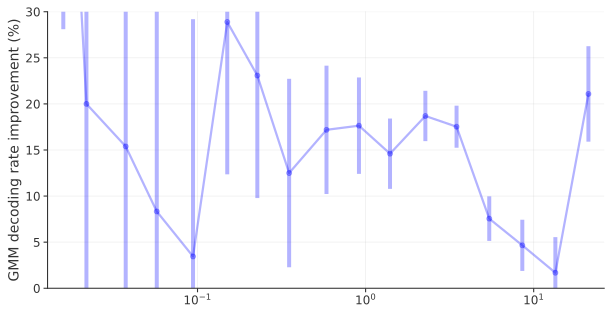

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.errorbar(mfr_corrected, 100*s_d.decoding_error_rate_improvement, yerr = 100*s_d.decoding_error_rate_improvement_err, label="improvement", color="blue", ls="-", marker="o", markersize=5, alpha=0.3, elinewidth=4, capsize=0)
ax.set_ylim(0,30)
ax.set_xscale('log')
ax.set_ylabel("GMM decoding rate improvement (%)")

In [15]:
# I feel like it would accutally be decent to decode more data, and get the error bars working. We definitely should have significant 
# error bars because for some of these decodings, only 1-10 events were decoded as incorrect. You are dividing by 99% by the end here...


# I could just be nice to say that the gmm decloding is consistently about 20% better than the slope decoding.

# is it correct to focus specifically on failed events? 

# yes, if the rate of failures goes down by a certain percentage that's important

(1.0, 0.8)

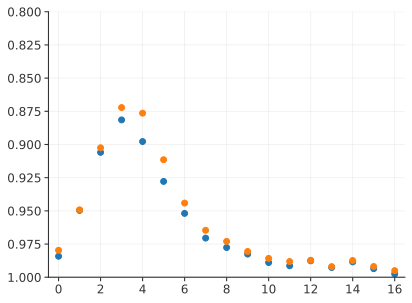

In [17]:
plt.plot(max_list_ccs, 'o')
plt.plot(max_list_org_ccs, 'o')
plt.ylim(1,.80)

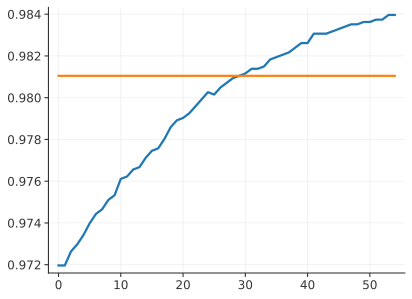

In [18]:
plt.plot(np.arange(len(list_cc)), list_cc)
plt.plot(np.arange(len(list_cc)), list_org_cc)

In [36]:
dB_idx = 6

new_results = decode_results(decodes[dB_idx], slice=0, offset=offsets[dB_idx])
cc = 0
org_cc = 0
for event in new_results:
    if event.result == Result.CORRECT:
        cc += 1
    if event.true == event.measured:
        org_cc += 1
cc = cc/len(new_results)
org_cc = org_cc/len(new_results)
print(f"cc: {round(cc,4)}, org_cc: {round(org_cc,4)}, offset: {offsets[dB_idx]}")

# not working....

cc: 0.9507, org_cc: 0.9453, offset: -0.10799999999999998


In [9]:
offsets[dB_idx]

-0.10999999999999999

In [25]:
len(decodes)

17